In [3]:
#TODO funkcja trenująca powinna aktualizować słowniki w checkpoint.pth przypadku wczytania modelu
from data_helper import get_dataloaders_and_standarscaler_photons_from_numpy
from train_helper import train_vae
from plot_helper import plot_training_loss

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [4]:
# Hyperparameters
RANDOM_SEED = 123
NUM_EPOCHS = 1
LOGGING_INTERVAL=300

# RECONSTRUCTION_TERM_WEIGHT=2.8 
# LEARNING_RATE = 0.0005
# BATCH_SIZE = 1024
#TOTAL_NUM_EPOCHS
# SAVE_MODEL_FILE

PLOT_FRACTION=0.0125
TEST_FRACTION=0.4
VALIDATION_FRACTION=0.0
NUM_WORKERS=0
path='/data1/dose-3d-generative/data/training-data/DISP_0.5_ANGLE_0/NUMPY/a1_10_7.npy'
CHECKPOINT_PATH="TrainedModels/BetaVAE/22epoch_0103_checkpoint.pth"

In [71]:
loaded_checkpoint = torch.load(CHECKPOINT_PATH)

BATCH_SIZE = loaded_checkpoint["batch_size"]
RECONSTRUCTION_TERM_WEIGHT = loaded_checkpoint["reconstruction_term_weight"]
log_dict_old=loaded_checkpoint["log_dict"]

epoch = loaded_checkpoint["epoch"]
print(epoch)
TOTAL_NUM_EPOCHS=epoch+NUM_EPOCHS
model_name=loaded_checkpoint["model_name"]
print(model_name)

22
VAE_Linear_0103


In [72]:
SAVE_MODEL_FILE=f'TrainedModels/BetaVAE/{TOTAL_NUM_EPOCHS}epoch_0103_checkpoint.pth'#None gdy nie tworzy się nowego zapisu

In [5]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [6]:
print(torch.cuda.memory_allocated(device=DEVICE))
print(torch.cuda.memory_reserved(device=DEVICE))
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0).total_memory)

0
0
Quadro RTX 8000
50959679488


In [75]:
model = getattr(__import__('models_architecture_helper', fromlist=[model_name]), model_name)

In [76]:
model=model()
model.to(DEVICE)
model.load_state_dict(loaded_checkpoint["model_state"])

optimizer = torch.optim.Adam(model.parameters(),
                             lr=0, 
                             weight_decay=1e-5)

optimizer.load_state_dict(loaded_checkpoint["optim_state"])

#print(optimizer.state_dict)

In [77]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros((10000001, 6),dtype=np.float32)
np.copyto(X,photons[:,:-1])
print(X.shape)

# photons = np.load(path)
# X = np.zeros(photons.shape,dtype=np.float32)
# np.copyto(X,photons)

(10000001, 6)


In [78]:
X_reflection=copy.deepcopy(X)
X_reflection[:,2]=-X_reflection[:,2]
X_reflection[:,4]=-X_reflection[:,4]

X_sum=np.concatenate((X,X_reflection),axis=0)
print(len(X_sum))

20000002


In [79]:
df_data = pd.DataFrame(X_sum, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.77526,-0.50856,-4.60704,-0.018979,-0.177872,0.983871
1,0.77526,-0.77813,-5.10840,-0.029292,-0.196501,0.980066
2,0.45010,-3.74409,-1.33591,-0.145330,-0.051869,0.988023
3,0.39630,-2.50916,-3.30103,-0.274393,-0.273584,0.921879
4,0.45010,-4.79711,-1.70242,-0.184824,-0.065606,0.980579


In [80]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons_from_numpy(tmp_X=X_sum,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    test_fraction=TEST_FRACTION, 
    validation_fraction=VALIDATION_FRACTION)

In [81]:
# model = VAE_Linear()
# model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr=LEARNING_RATE, 
#                              weight_decay=1e-5)

In [82]:
log_dict_new=train_vae(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=RECONSTRUCTION_TERM_WEIGHT, save_model_file=SAVE_MODEL_FILE, total_num_of_epochs=TOTAL_NUM_EPOCHS)



Epoch: 001/001 | Batch 0000/1200 | Loss: 4.9018
Epoch: 001/001 | Batch 0300/1200 | Loss: 4.8352
Epoch: 001/001 | Batch 0600/1200 | Loss: 4.8481
Epoch: 001/001 | Batch 0900/1200 | Loss: 5.0420
***Epoch: 001/001 | Loss: 1.981
Test***Epoch: 001/001 | Loss: 1.982
Time elapsed: 8.32 min
Total Training Time: 8.32 min


In [83]:
log_dict={ key:log_dict_old.get(key,[])+log_dict_new.get(key,[]) for key in set(list(log_dict_old.keys())+list(log_dict_new.keys())) }

In [84]:
print(len(log_dict["test_combined_loss_per_epoch"]))

2


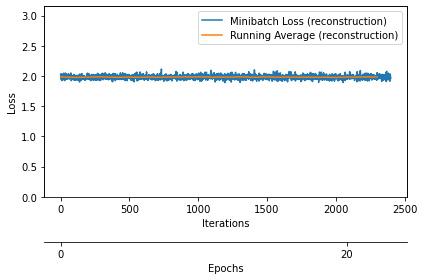

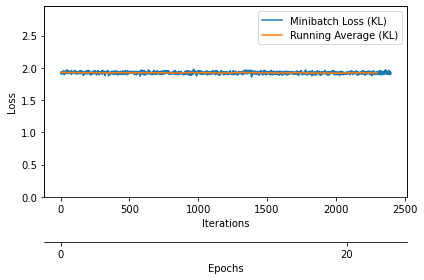

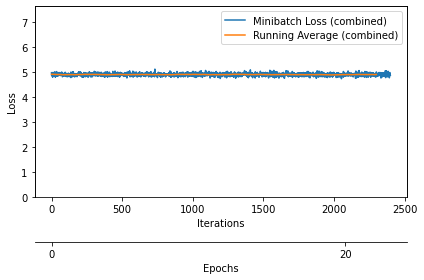

In [85]:
epoch_all=epoch+NUM_EPOCHS
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], epoch_all, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], epoch_all, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], epoch_all, custom_label=" (combined)")
plt.show()



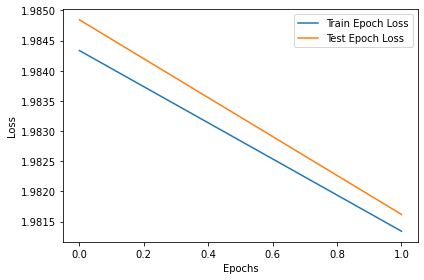

In [86]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [87]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
model.eval()
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

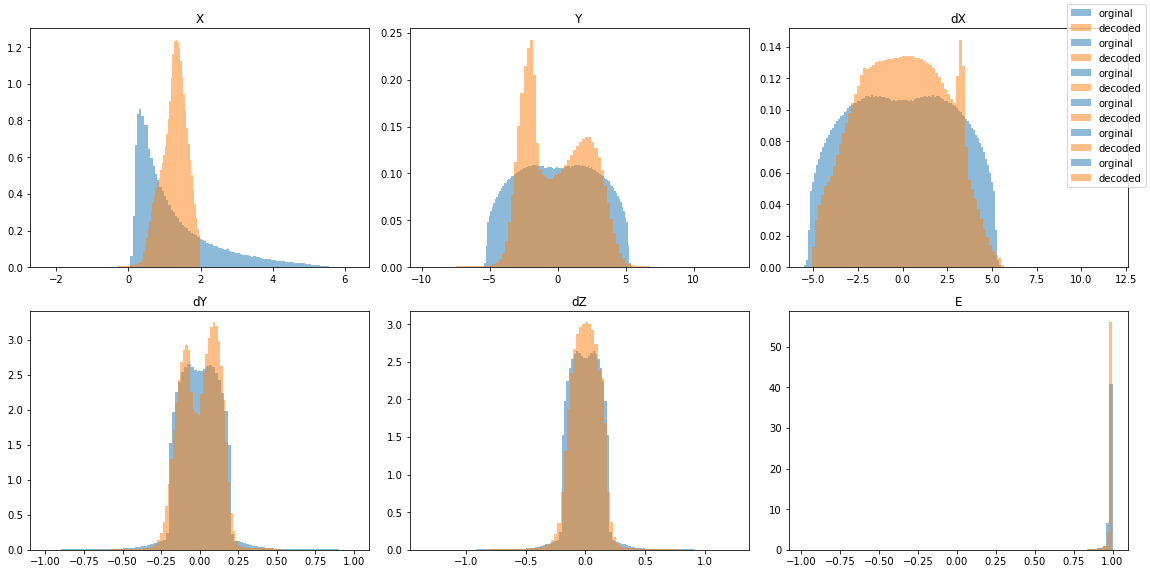

In [88]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

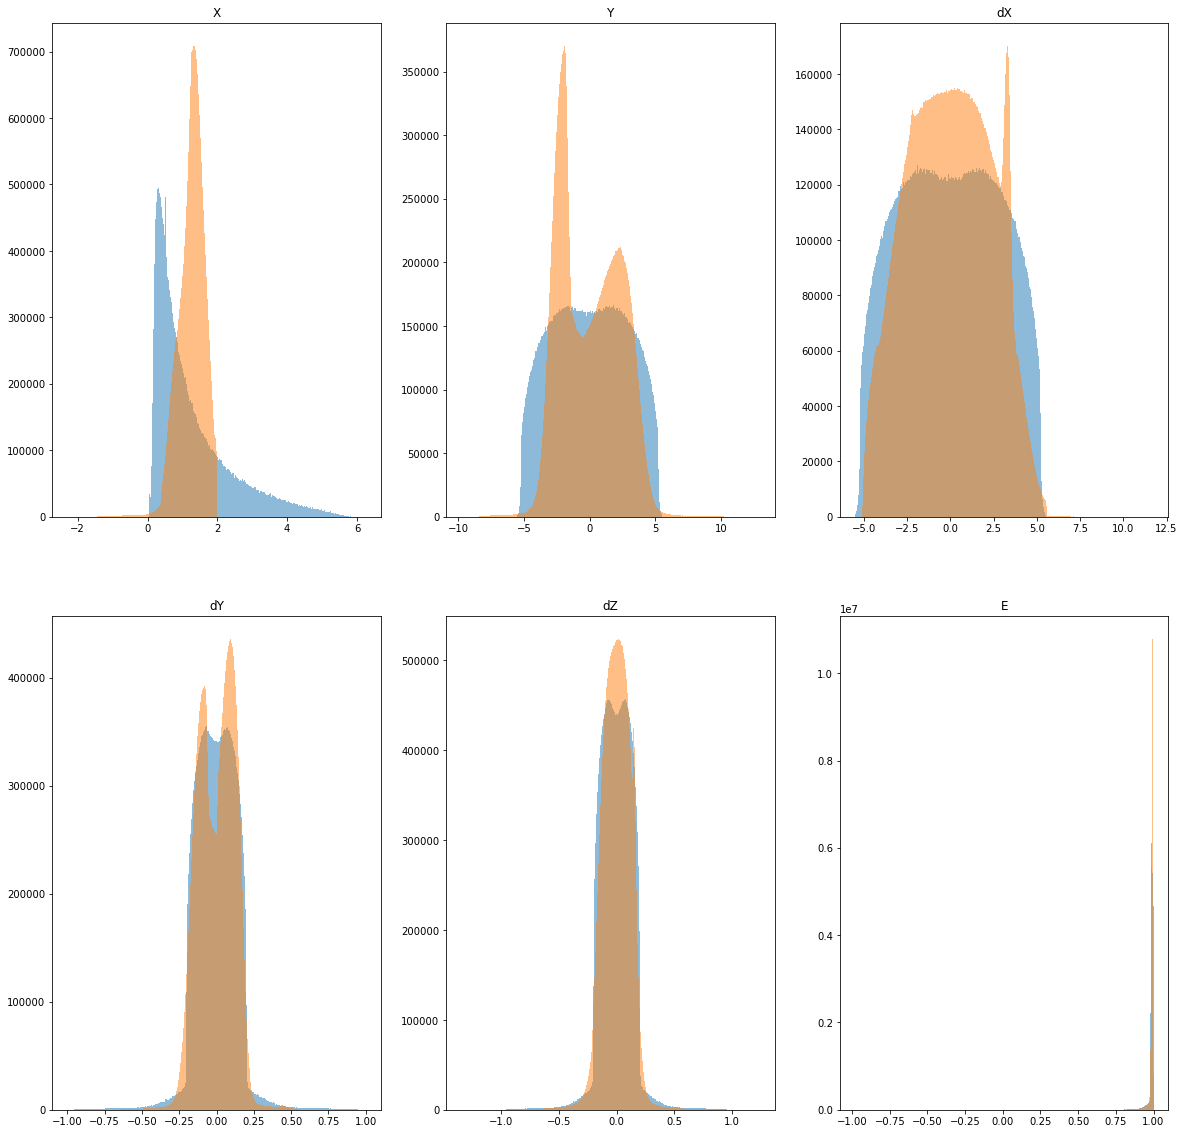

In [89]:
keys = df_data.columns
# print(keys)
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    # print(bins)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(j)


In [90]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [91]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample_concatenated=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=PLOT_FRACTION, random_state=2)) 
print(sample_concatenated.shape)
print(sample_concatenated.head())

(500000, 7)
                 X         Y        dX        dY        dZ         E  \
31583840  1.550452  1.562180  0.165552  0.092991 -0.004322  0.991796   
34539943  1.362522  1.779805  1.762215  0.085531  0.070639  0.988399   
20004843  1.024498  3.799315 -3.946529  0.199297 -0.178686  0.987717   
20169494  1.517201  1.071221  3.311874  0.049933  0.137114  0.989389   
38060417  1.168028 -2.754622  2.198189 -0.159047  0.108174  0.983630   

         dataset_name  
31583840      decoded  
34539943      decoded  
20004843      decoded  
20169494      decoded  
38060417      decoded  


In [92]:
sns.pairplot(sample_concatenated, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))
#sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f5e3f67c5e0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
sample_orginal=orginal_df.apply(lambda x: x.sample(frac=PLOT_FRACTION, random_state=2)) 
print(sample_orginal.shape)
print(sample_orginal.head())

(250000, 6)
                X        Y       dX        dY        dZ         E
11583838  0.72217  1.91911  1.02320  0.075932  0.040737  0.996280
14539941  0.19622  2.45577  4.91175  0.094408  0.188461  0.977532
4841      0.36820  3.95641 -3.81723  0.152133 -0.146734  0.977407
169492    1.24696  4.82186 -0.47056 -0.187327  0.301854  0.934769
18060415  0.46350 -3.66491  2.14019 -0.309671  0.214503  0.926333


In [ ]:
#sns.pairplot(sample_orginal, kind="scatter")

In [ ]:
sample_decoded=decoded_df.apply(lambda x: x.sample(frac=PLOT_FRACTION, random_state=2)) 
print(sample_decoded.shape)
print(sample_decoded.head())

(250000, 6)
                 X         Y        dX        dY        dZ         E
11583838  0.731553  3.192537  2.781394  0.118370  0.128844  0.979185
14539941  0.886279  2.499064  4.335417  0.082993  0.195589  0.980283
4841      0.829720  3.772212 -1.541460  0.176044 -0.067058  0.983016
169492    1.234492  2.185653  1.338924  0.101381  0.054369  0.986590
18060415  0.916559 -3.228789  2.317587 -0.196683  0.121456  0.980278


In [ ]:
# sns.pairplot(sample_decoded, kind="scatter")

In [ ]:
# g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
# g.map_upper(sns.scatterplot)
# #g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

In [ ]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [ ]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [ ]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.359750,2.614970,-4.698670,0.100502,-0.180584,0.978411
1,1.276894,1.770341,-3.021125,0.105573,-0.138899,0.989414


In [ ]:
encoded_features=[]
model.eval()
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(12000000, 3)


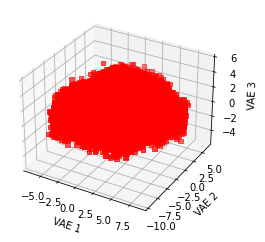

In [ ]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,1],encoded_features[:,2],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()